In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# For example, here's several helpful packages to load



import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



# Input data files are available in the read-only "../input/" directory

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



import os

for dirname, _, filenames in os.walk('/kaggle/input'):

    for filename in filenames:

        print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kvasirseg/val.txt
/kaggle/input/kvasirseg/README.md
/kaggle/input/kvasirseg/train.txt
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/1911.07069.pdf
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju7d1tvt25bu08019dvw3uff.jpg
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju30qbm1ad3x0855znuhpz9u.jpg
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju5xq3tdm9fn0987pbedxdg5.jpg
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju7deifq2fzn0755lc8idyh8.jpg
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju2raxlosl630988jdbfy9b0.jpg
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju5uget8krjy0818kvywd0zu.jpg
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju8b1v3br45u087189kku66u.jpg
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju1hs0za7jha0855vj0mdrjt.jpg
/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju171py4qiha0835u8sl59ds.jpg
/k

# Import Required Libraries

In [2]:

import os

import numpy as np

import cv2

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch

import torch.nn as nn

import torch.optim as optim

import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from torchvision import models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Step 2: Data Preprocessing and Augmentation


In [3]:

DATA_PATH = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG" 

if not os.path.exists(DATA_PATH):

    raise FileNotFoundError(f"Data path {DATA_PATH} does not exist. Please check the path.")


transform = transforms.Compose([

    transforms.ToPILImage(),

    transforms.Resize((512, 512)), 

    transforms.RandomHorizontalFlip(),

    transforms.RandomVerticalFlip(),

    transforms.RandomRotation(10),

    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),

    transforms.ToTensor(),

])


In [4]:

class KvasirSegDataset(Dataset):

    def __init__(self, images, masks, transform=None):

        self.images = images

        self.masks = masks

        self.transform = transform



    def __len__(self):

        return len(self.images)



    def __getitem__(self, idx):

        img = cv2.imread(self.images[idx])

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)



        if self.transform:

            img = self.transform(img)

            mask = self.transform(mask)



        return img, mask


In [5]:

image_paths = sorted([os.path.join(DATA_PATH, "images", f) for f in os.listdir(os.path.join(DATA_PATH, "images"))])

mask_paths = sorted([os.path.join(DATA_PATH, "masks", f) for f in os.listdir(os.path.join(DATA_PATH, "masks"))])




print(f"Number of images: {len(image_paths)}")

print(f"Number of masks: {len(mask_paths)}")


Number of images: 1000
Number of masks: 1000


In [6]:

train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)



print(f"Training images: {len(train_images)}, Validation images: {len(val_images)}")

 

first_image = cv2.imread(image_paths[0])

first_mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)



print(f"Shape of the first image: {first_image.shape}")  
print(f"Shape of the first mask: {first_mask.shape}")   

Training images: 800, Validation images: 200
Shape of the first image: (529, 622, 3)
Shape of the first mask: (529, 622)


In [7]:
train_dataset = KvasirSegDataset(train_images, train_masks, transform)

val_dataset = KvasirSegDataset(val_images, val_masks, transform)



train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


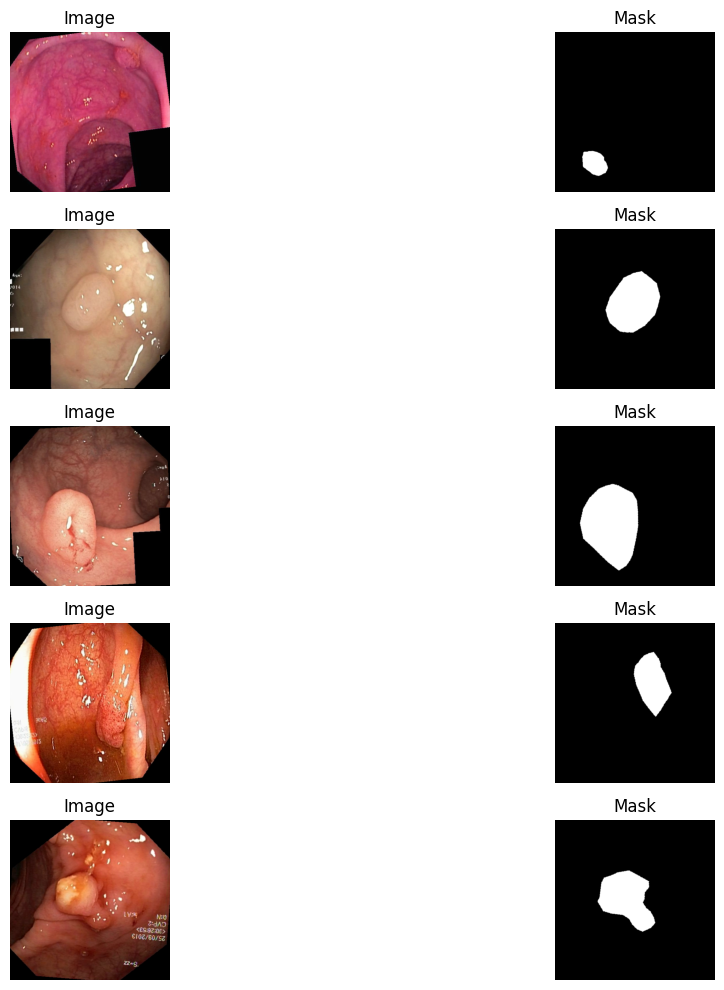

In [8]:
def visualize_samples(dataset, num_samples=5):

    plt.figure(figsize=(15, 10))

    for i in range(num_samples):

        image, mask = dataset[i]




        image = image.permute(1, 2, 0).numpy() 
        mask = mask.squeeze(0).numpy() 



        image = (image - image.min()) / (image.max() - image.min())



        plt.subplot(num_samples, 2, 2*i + 1)

        plt.imshow(image)

        plt.title('Image')

        plt.axis('off')



        plt.subplot(num_samples, 2, 2*i + 2)

        plt.imshow(mask, cmap='gray')

        plt.title('Mask')

        plt.axis('off')



    plt.tight_layout()

    plt.show()




visualize_samples(train_dataset, num_samples=5)


# Step 3: Define the u-Net Architecture


In [9]:

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1):

        super(UNet, self).__init__()

        self.encoder = models.resnet34(pretrained=True)

        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2]) 


        self.decoder1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)

        self.decoder2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)

        self.decoder3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)



    def forward(self, x):

        x1 = self.encoder(x) 

        x2 = self.decoder1(x1)

        x3 = self.decoder2(x2)

        x4 = self.decoder3(x3)

        return self.final_conv(x4)




unet_model = UNet().to(device)

print("Model architecture:")

print(unet_model)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


Model architecture:
UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

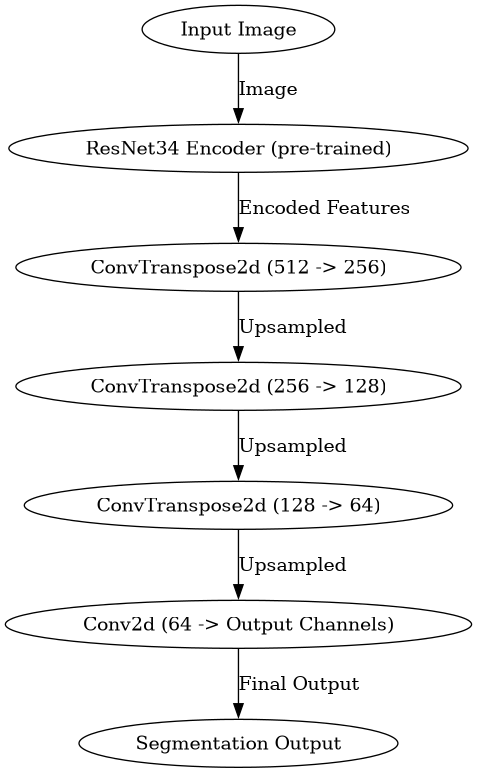

In [10]:
from graphviz import Digraph



def create_unet_block_diagram():

    dot = Digraph(format='png')

    

    dot.node('Input', 'Input Image')

    dot.node('ResNet Encoder', 'ResNet34 Encoder (pre-trained)')

    dot.node('Decoder1', 'ConvTranspose2d (512 -> 256)')

    dot.node('Decoder2', 'ConvTranspose2d (256 -> 128)')

    dot.node('Decoder3', 'ConvTranspose2d (128 -> 64)')

    dot.node('FinalConv', 'Conv2d (64 -> Output Channels)')

    dot.node('Output', 'Segmentation Output')


    dot.edge('Input', 'ResNet Encoder', label='Image')

    dot.edge('ResNet Encoder', 'Decoder1', label='Encoded Features')

    dot.edge('Decoder1', 'Decoder2', label='Upsampled')

    dot.edge('Decoder2', 'Decoder3', label='Upsampled')

    dot.edge('Decoder3', 'FinalConv', label='Upsampled')

    dot.edge('FinalConv', 'Output', label='Final Output')



    return dot

unet_diagram = create_unet_block_diagram()

unet_diagram.render('/mnt/data/unet_block_diagram')



# Display the diagram

unet_diagram_output = unet_diagram.pipe(format='png')



from IPython.display import Image

Image(unet_diagram_output)


In [11]:

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy

optimizer = optim.SGD(unet_model.parameters(), lr=0.001, momentum=0.9)

# Step 4: Training Loop


In [12]:
import torch

import torch.nn as nn

import torch.optim as optim




criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.SGD(unet_model.parameters(), lr=0.001, momentum=0.9)





def train_model(model, train_loader, criterion, optimizer, num_epochs=200):

    model.train()

    for epoch in range(num_epochs):

        running_loss = 0.0

        for images, masks in train_loader:

            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            outputs = model(images)




            outputs = nn.functional.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)


            masks = masks.squeeze(2) 

            loss = criterion(outputs, masks.float()) 

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")



# Train 

train_model(unet_model, train_loader, criterion, optimizer)


Epoch [1/200], Loss: 0.6519
Epoch [2/200], Loss: 0.5303
Epoch [3/200], Loss: 0.4652
Epoch [4/200], Loss: 0.4320
Epoch [5/200], Loss: 0.4154
Epoch [6/200], Loss: 0.4047
Epoch [7/200], Loss: 0.3970
Epoch [8/200], Loss: 0.3921
Epoch [9/200], Loss: 0.3874
Epoch [10/200], Loss: 0.3835
Epoch [11/200], Loss: 0.3796
Epoch [12/200], Loss: 0.3763
Epoch [13/200], Loss: 0.3725
Epoch [14/200], Loss: 0.3702
Epoch [15/200], Loss: 0.3683
Epoch [16/200], Loss: 0.3654
Epoch [17/200], Loss: 0.3645
Epoch [18/200], Loss: 0.3627
Epoch [19/200], Loss: 0.3599
Epoch [20/200], Loss: 0.3581
Epoch [21/200], Loss: 0.3546
Epoch [22/200], Loss: 0.3502
Epoch [23/200], Loss: 0.3512
Epoch [24/200], Loss: 0.3458
Epoch [25/200], Loss: 0.3472
Epoch [26/200], Loss: 0.3470
Epoch [27/200], Loss: 0.3411
Epoch [28/200], Loss: 0.3414
Epoch [29/200], Loss: 0.3407
Epoch [30/200], Loss: 0.3389
Epoch [31/200], Loss: 0.3373
Epoch [32/200], Loss: 0.3336
Epoch [33/200], Loss: 0.3324
Epoch [34/200], Loss: 0.3305
Epoch [35/200], Loss: 0

# Step 5: Calculation metrics


Validation Loss: 0.3073
Accuracy: 92.97%
Precision: 79.31%
Recall: 58.0%
Dice Coefficient: 65.18%


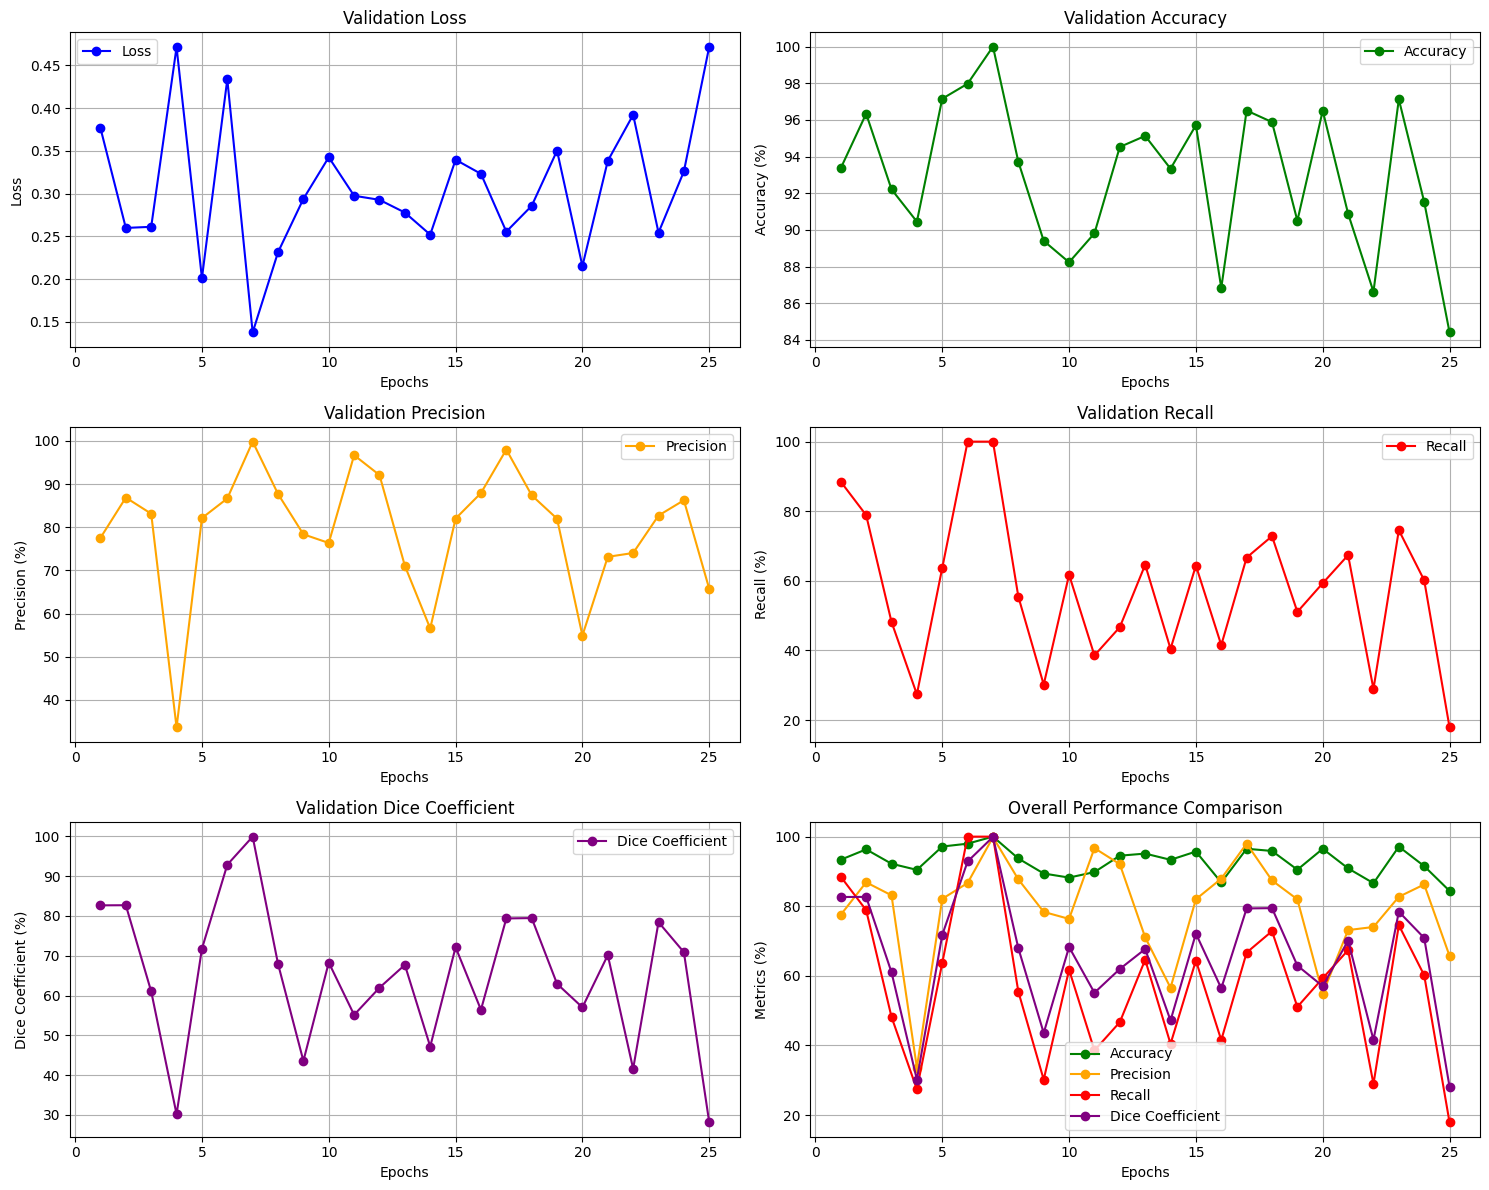

In [13]:
import torch

import torch.nn.functional as F

import matplotlib.pyplot as plt




def calculate_metrics(outputs, masks, threshold=0.5):
    preds = torch.sigmoid(outputs)

    preds = (preds > threshold).float()

    preds_flat = preds.view(-1)

    masks_flat = masks.view(-1)

    tp = (preds_flat * masks_flat).sum().item()

    fp = ((preds_flat == 1) & (masks_flat == 0)).sum().item()

    fn = ((preds_flat == 0) & (masks_flat == 1)).sum().item()

    tn = ((preds_flat == 0) & (masks_flat == 0)).sum().item()


    accuracy = (tp + tn) / (tp + fp + fn + tn)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    dice = (2 * tp) / (2 * tp + fp + fn) if (tp + fp + fn) > 0 else 0

    return accuracy, precision, recall, dice

def evaluate_model(model, val_loader, criterion):

    model.eval()

    running_loss = 0.0

    total_accuracy = 0.0

    total_precision = 0.0

    total_recall = 0.0

    total_dice = 0.0

    total_batches = 0



    metrics = {

        "loss": [],

        "accuracy": [],

        "precision": [],

        "recall": [],

        "dice": []

    }



    with torch.no_grad():

        for images, masks in val_loader:

            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            outputs = nn.functional.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
            masks = masks.squeeze(2)
            loss = criterion(outputs, masks.float())

            running_loss += loss.item()

            accuracy, precision, recall, dice = calculate_metrics(outputs, masks)
            total_accuracy += accuracy
            total_precision += precision
            total_recall += recall
            total_dice += dice
            total_batches += 1
            metrics["loss"].append(loss.item())
            metrics["accuracy"].append(accuracy * 100) 
            metrics["precision"].append(precision * 100)
            metrics["recall"].append(recall * 100)
            metrics["dice"].append(dice * 100)

    avg_loss = running_loss / total_batches
    avg_accuracy = total_accuracy / total_batches * 100
    avg_precision = total_precision / total_batches * 100
    avg_recall = total_recall / total_batches * 100
    avg_dice = total_dice / total_batches * 100
    print(f"Validation Loss: {avg_loss:.4f}")

    print(f"Accuracy: {avg_accuracy:.2f}%")
    print(f"Precision: {avg_precision:.2f}%")
    print(f"Recall: {avg_recall:.1f}%")
    print(f"Dice Coefficient: {avg_dice:.2f}%")

    epochs = range(1, len(metrics["accuracy"]) + 1)
    plt.figure(figsize=(15, 12))
    plt.subplot(3, 2, 1)

    plt.plot(epochs, metrics["loss"], label='Loss', color='blue', marker='o')

    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()

    plt.legend()
    plt.subplot(3, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label='Accuracy', color='green', marker='o')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid()
    plt.legend()
    plt.subplot(3, 2, 3)

    plt.plot(epochs, metrics["precision"], label='Precision', color='orange', marker='o')
    plt.title('Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision (%)')
    plt.grid()

    plt.legend()
    plt.subplot(3, 2, 4)
    plt.plot(epochs, metrics["recall"], label='Recall', color='red', marker='o')
    plt.title('Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall (%)')
    plt.grid()
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(epochs, metrics["dice"], label='Dice Coefficient', color='purple', marker='o')
    plt.title('Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient (%)')
    plt.grid()
    plt.legend()
    
    plt.subplot(3, 2, 6)
    plt.plot(epochs, metrics["accuracy"], label='Accuracy', color='green', marker='o')
    plt.plot(epochs, metrics["precision"], label='Precision', color='orange', marker='o')
    plt.plot(epochs, metrics["recall"], label='Recall', color='red', marker='o')
    plt.plot(epochs, metrics["dice"], label='Dice Coefficient', color='purple', marker='o')
    plt.title('Overall Performance Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics (%)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
evaluate_model(unet_model, val_loader, criterion)


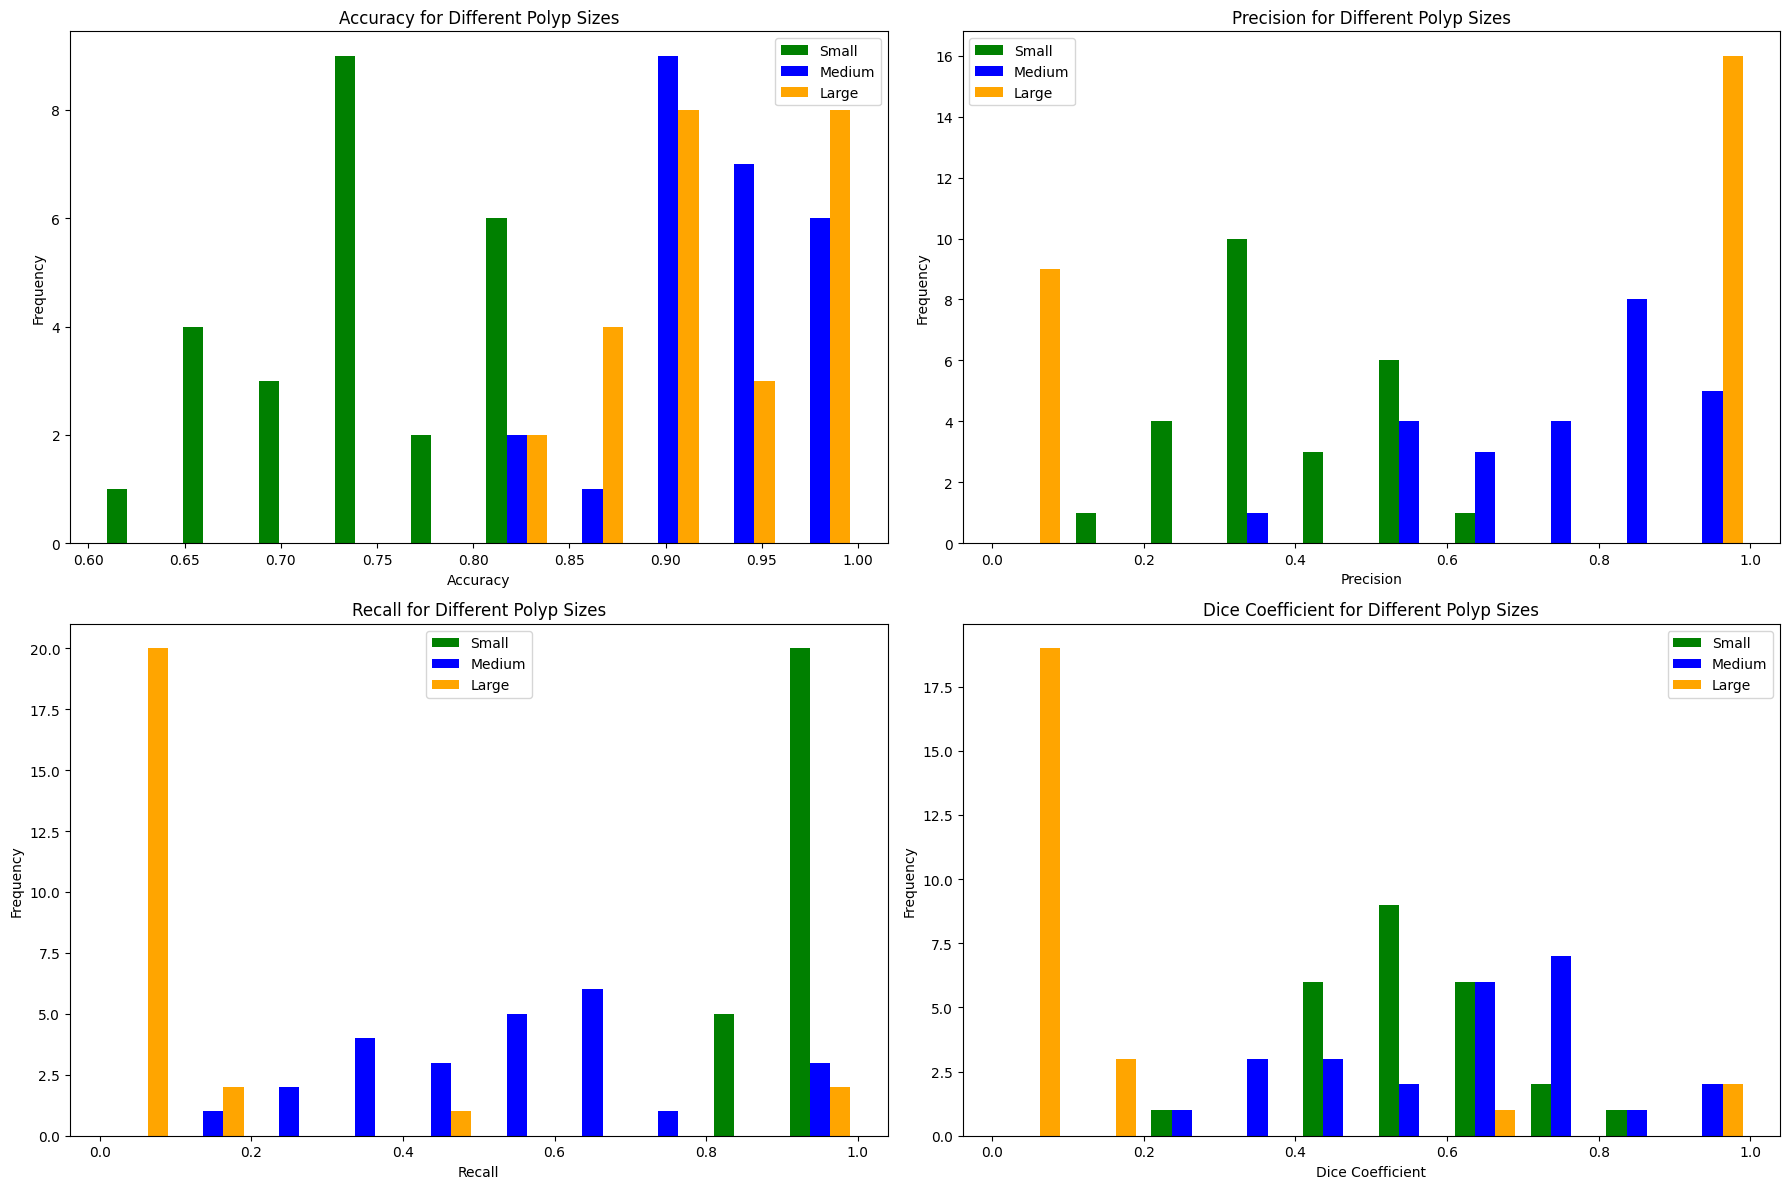

In [14]:
def evaluate_and_plot(model, loader, criterion):

    model.eval()

    sizes = ['small', 'medium', 'large']

    thresholds = [0.1, 0.5, 0.9]  

    metrics = {size: {'accuracy': [], 'precision': [], 'recall': [], 'dice': []} for size in sizes}

    with torch.no_grad():

        for images, masks in loader:

            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            outputs = nn.functional.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)



            for i, size in enumerate(sizes):

                acc, prec, rec, dice = calculate_metrics(outputs, masks, threshold=thresholds[i])

                metrics[size]['accuracy'].append(acc)

                metrics[size]['precision'].append(prec)

                metrics[size]['recall'].append(rec)

                metrics[size]['dice'].append(dice)




    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)

    plt.hist([metrics['small']['accuracy'], metrics['medium']['accuracy'], metrics['large']['accuracy']], 

             label=['Small', 'Medium', 'Large'], bins=10, color=['green', 'blue', 'orange'])

    plt.title('Accuracy for Different Polyp Sizes')

    plt.xlabel('Accuracy')

    plt.ylabel('Frequency')

    plt.legend()

    plt.subplot(2, 2, 2)

    plt.hist([metrics['small']['precision'], metrics['medium']['precision'], metrics['large']['precision']], 

             label=['Small', 'Medium', 'Large'], bins=10, color=['green', 'blue', 'orange'])

    plt.title('Precision for Different Polyp Sizes')

    plt.xlabel('Precision')

    plt.ylabel('Frequency')

    plt.legend()


    plt.subplot(2, 2, 3)

    plt.hist([metrics['small']['recall'], metrics['medium']['recall'], metrics['large']['recall']], 

             label=['Small', 'Medium', 'Large'], bins=10, color=['green', 'blue', 'orange'])

    plt.title('Recall for Different Polyp Sizes')

    plt.xlabel('Recall')

    plt.ylabel('Frequency')

    plt.legend()


    plt.subplot(2, 2, 4)

    plt.hist([metrics['small']['dice'], metrics['medium']['dice'], metrics['large']['dice']], 

             label=['Small', 'Medium', 'Large'], bins=10, color=['green', 'blue', 'orange'])

    plt.title('Dice Coefficient for Different Polyp Sizes')

    plt.xlabel('Dice Coefficient')

    plt.ylabel('Frequency')

    plt.legend()



    plt.tight_layout()

    plt.show()


evaluate_and_plot(unet_model, val_loader, criterion)


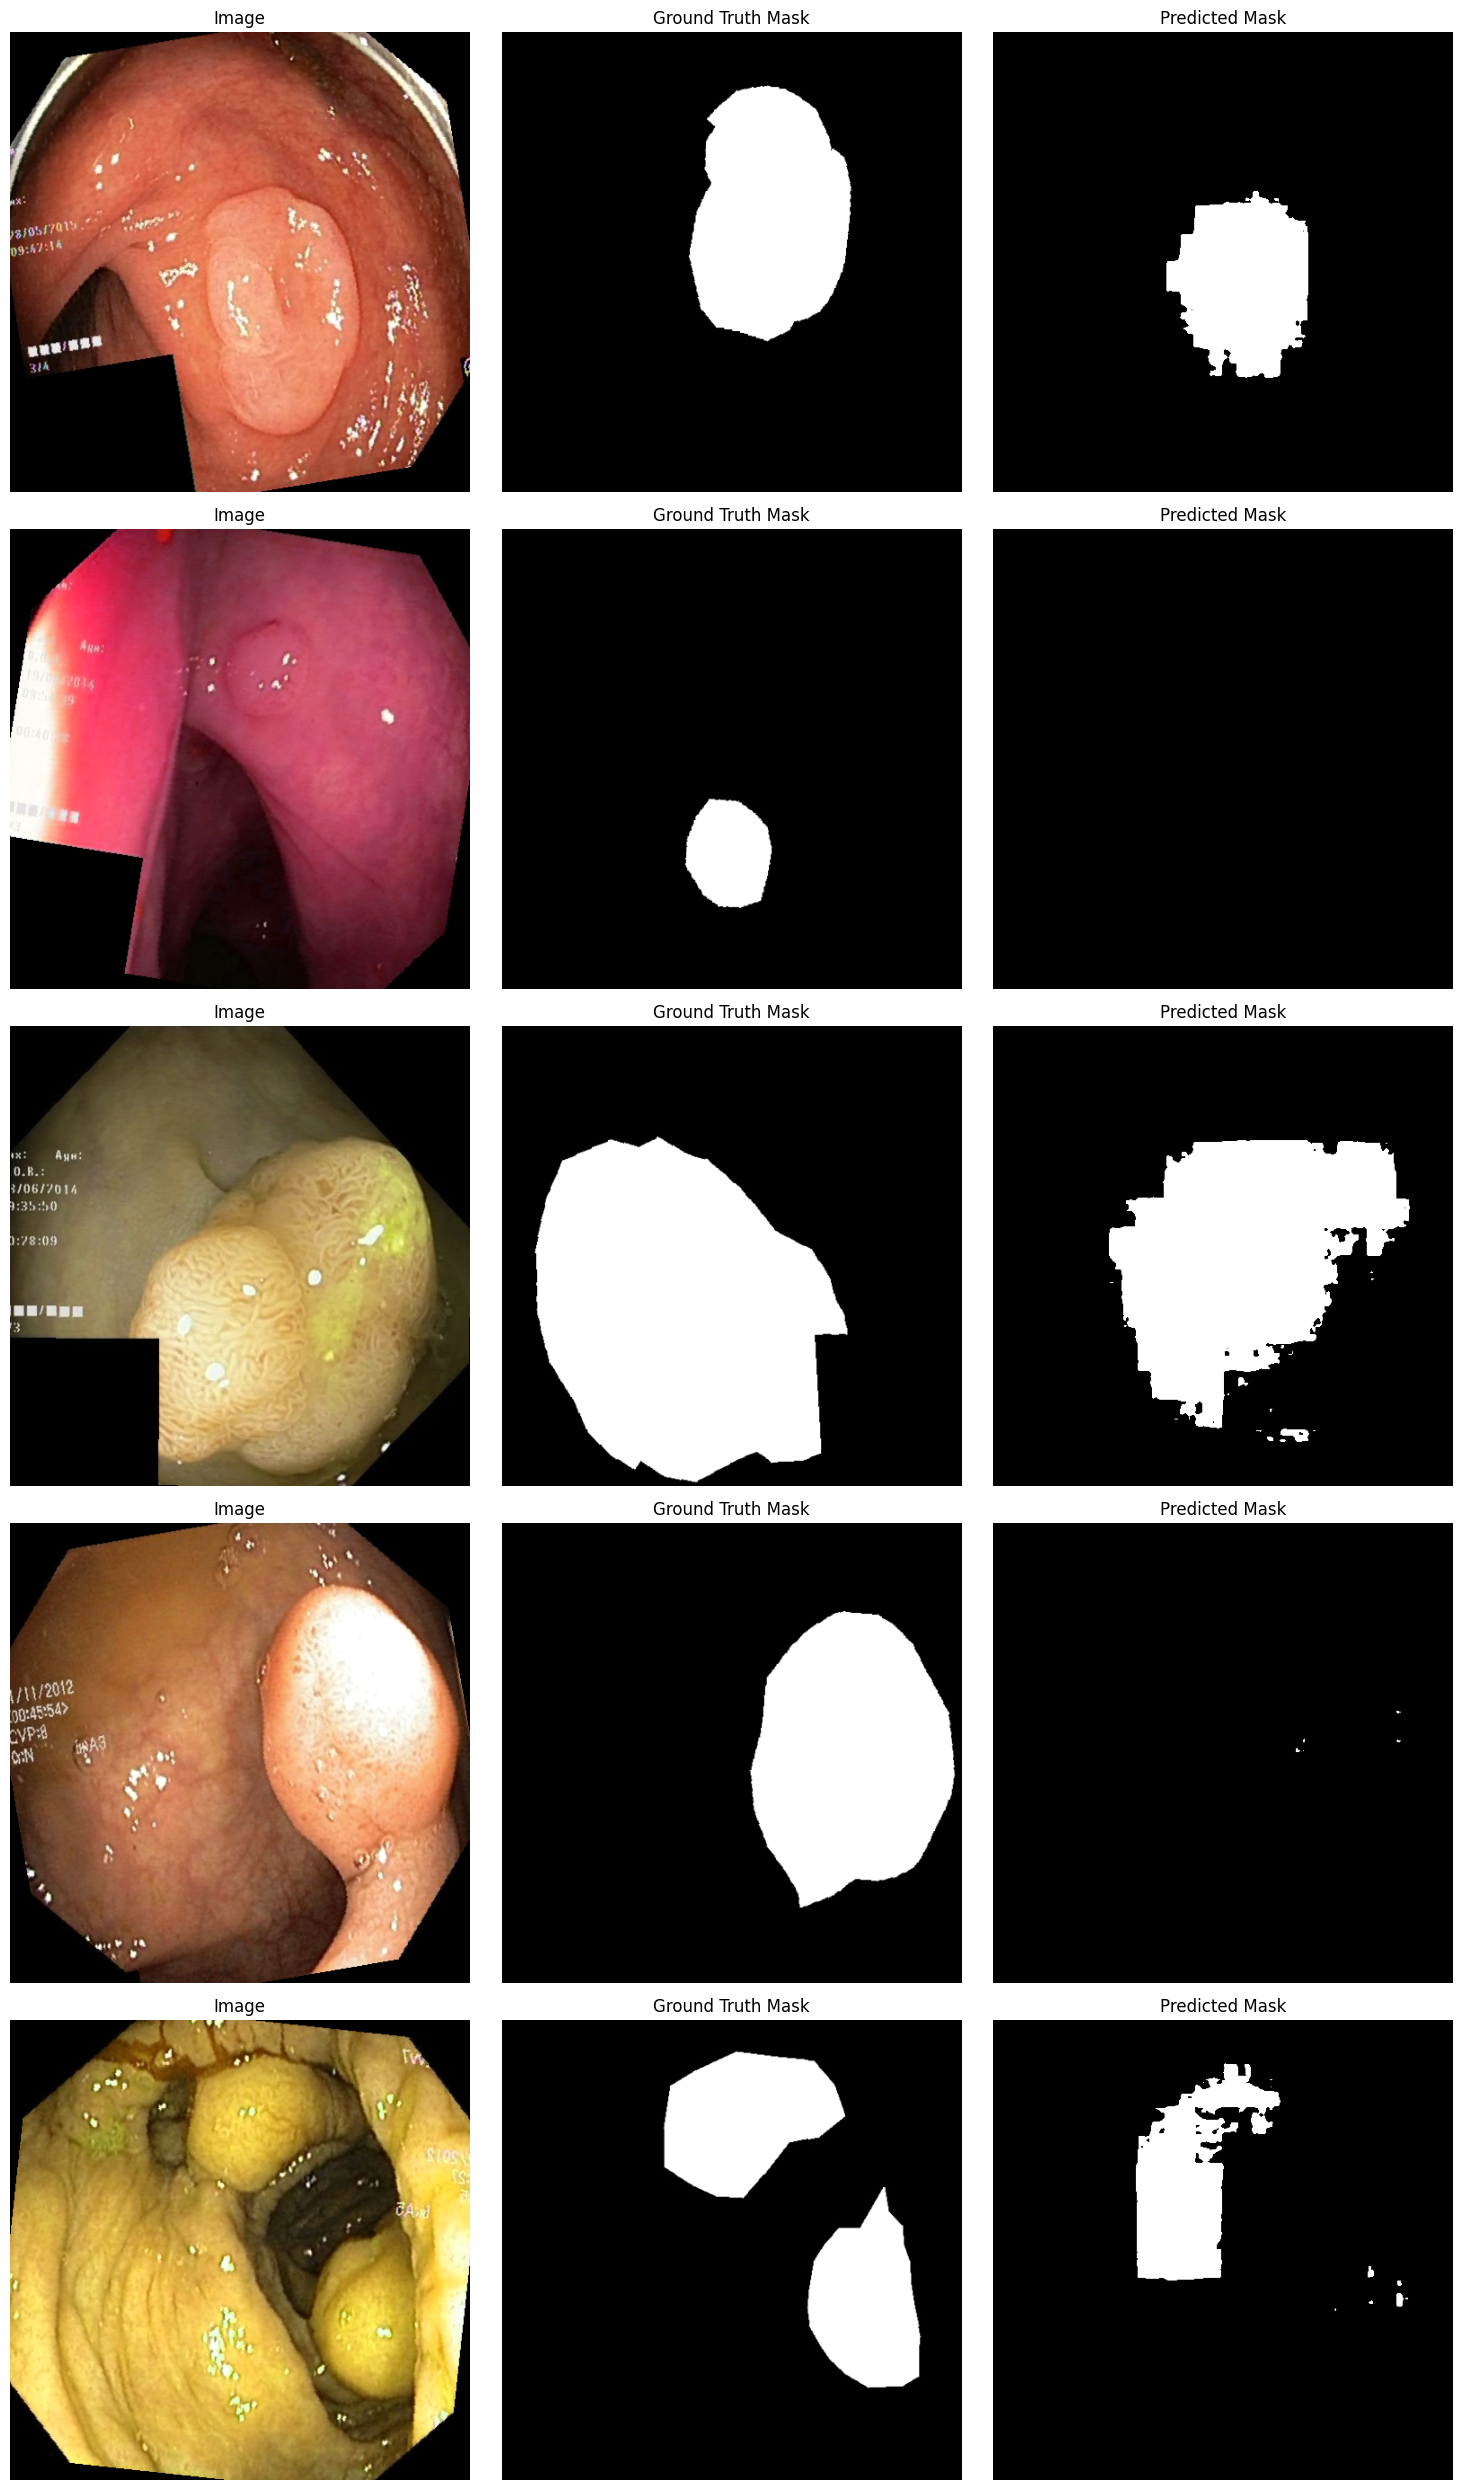

In [15]:
def predict_and_visualize(model, loader, num_samples=5):

    model.eval()  

    samples = []

    with torch.no_grad(): 

        for i, (images, masks) in enumerate(loader):

            images = images.to(device)

            outputs = model(images)

            outputs = nn.functional.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
            preds = torch.sigmoid(outputs) > 0.5 
            images = images.cpu()

            preds = preds.cpu()

            masks = masks.cpu()

            for j in range(min(num_samples, images.size(0))):

                samples.append((images[j], preds[j], masks[j]))
            if len(samples) >= num_samples:

                break
    visualize_predictions(samples)
def visualize_predictions(samples):

    num_samples = len(samples)

    plt.figure(figsize=(15, num_samples * 5))
    for i, (image, pred, mask) in enumerate(samples):

        image = image.permute(1, 2, 0).numpy()  

        image = (image - image.min()) / (image.max() - image.min())  

        pred = pred.squeeze().numpy()  

        mask = mask.squeeze().numpy() 

        plt.subplot(num_samples, 3, i * 3 + 1)

        plt.imshow(image)

        plt.title('Image')

        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)

        plt.imshow(mask, cmap='gray')

        plt.title('Ground Truth Mask')

        plt.axis('off')

        
        plt.subplot(num_samples, 3, i * 3 + 3)

        plt.imshow(pred, cmap='gray')

        plt.title('Predicted Mask')

        plt.axis('off')



    plt.tight_layout()

    plt.show()

predict_and_visualize(unet_model, val_loader, num_samples=5)
